# James Artuso
# Programming Exercise \#4
---

# Preamble

In [ ]:
# import relevant Python libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

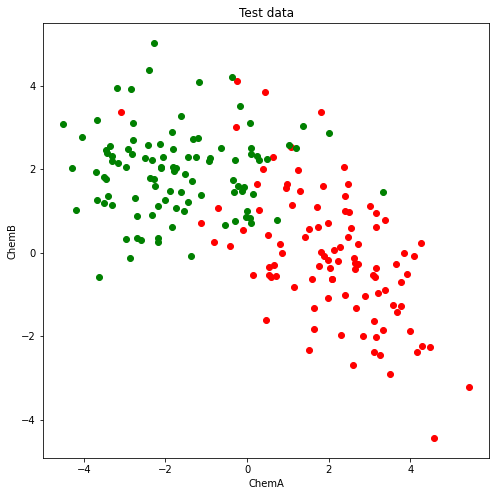

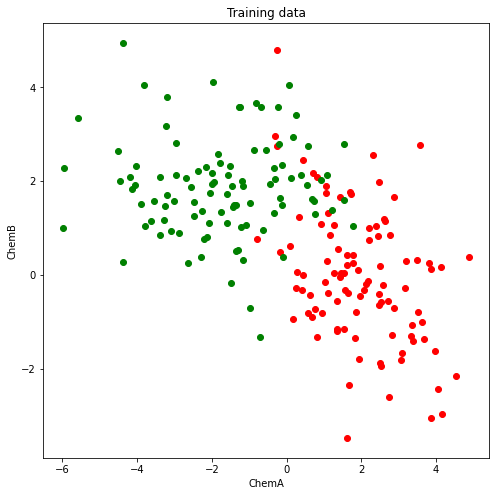

In [ ]:
df_test = pd.read_csv('/content/SenioritisTestData.csv')
df_train = pd.read_csv('/content/SenioritisTrainingData.csv')
testSenioritis = df_test.loc[df_test['ClassLabel'] == 'Senioritis']
testNoSenioritis =df_test.loc[df_test['ClassLabel'] != 'Senioritis']
testPlot = plt.figure(figsize = [8,8])
plt.scatter(testSenioritis['ChemA'], testSenioritis['ChemB'], c='r')
plt.scatter(testNoSenioritis['ChemA'], testNoSenioritis['ChemB'], c='g')
plt.title('Test data')
plt.xlabel('ChemA')
plt.ylabel('ChemB')
plt.show()

trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis =df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [8,8])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')
plt.title('Training data')
plt.xlabel('ChemA')
plt.ylabel('ChemB')
plt.show()

## Problem 1.2

### (a)

In [ ]:
classes = df_train.groupby('ClassLabel')

mu_LDA = classes.mean().to_numpy()


cov = np.zeros([2,2])
classNames = ['No Senioritis', 'Senioritis']

#.cov uses the unbiased version of calculating variance.
# I want to use the biased version, so I am multiplying by
# (n_l-1) and then dividing by (n). This is inline with the 
# formula provided in the notes.
C = classes.cov()
C = C.loc['No Senioritis']*(classes.get_group('No Senioritis').shape[0]-1) + C.loc['Senioritis']*(classes.get_group('Senioritis').shape[0]-1)
C_LDA = (C/(df_train.shape[0])).to_numpy()

priors_LDA = (df_train.value_counts(['ClassLabel'])/df_train.shape[0]).to_numpy()

def LDA(sample):
  delta = np.zeros(2)
  for i in range(2):
      d = np.matmul(sample.T, np.matmul(np.linalg.inv(C_LDA), mu_LDA[i]))
      d = d - 0.5 * np.matmul(mu_LDA[i].T, np.matmul(np.linalg.inv(C_LDA), mu_LDA[i]))
      d = d + np.log(priors_LDA[i])
      delta[i] = d
  return np.argmax(delta)

### (b)

In [ ]:
classes = df_train.groupby('ClassLabel')

mu_QDA = classes.mean().to_numpy()

C = classes.cov()

#Same situation here. cov gives unbiased, I want biased. This means 
# multiplying by (n_l-1) and dividing by (n_l).
C_QDA = np.zeros([2,2,2])
C_QDA[0] = (C.loc['No Senioritis']*((classes.get_group('No Senioritis').shape[0]-1)/classes.get_group('No Senioritis').shape[0])).to_numpy()
C_QDA[1] = (C.loc['Senioritis']*((classes.get_group('Senioritis').shape[0]-1)/classes.get_group('Senioritis').shape[0])).to_numpy()
priors_QDA = (df_train.value_counts(['ClassLabel'])/df_train.shape[0]).to_numpy()
def QDA(sample):
  delta = np.zeros(2)
  for i in range(2):
      d = -0.5*np.matmul((sample),np.matmul( np.linalg.inv(C_QDA[i]), sample.T))
      d = d + np.matmul((sample),np.matmul( np.linalg.inv(C_QDA[i]), mu_QDA[i]))
      d = d - 0.5 * np.matmul((mu_QDA[i]), np.matmul(np.linalg.inv(C_QDA[i]), mu_QDA[i]))
      d = d - 0.5 * np.log(np.linalg.det(C_QDA[i])) + np.log(priors_QDA[i])
      delta[i] = d
  if(delta[0] > delta[1]):
    return 0
  return 1

### (c)

In [ ]:
classes = df_train.groupby('ClassLabel')

mu_GNB = classes.mean().to_numpy()

C = classes.cov()

#Do this multiplication because we want biased version. .cov returns the unbiased version
C_GNB = np.zeros([2,2,2])
C_GNB[0] = (C.loc['No Senioritis']*((classes.get_group('No Senioritis').shape[0]-1)/classes.get_group('No Senioritis').shape[0])).to_numpy()
C_GNB[1] = (C.loc['Senioritis']*((classes.get_group('Senioritis').shape[0]-1)/classes.get_group('Senioritis').shape[0])).to_numpy()

priors_GNB = (df_train.value_counts(['ClassLabel'])/df_train.shape[0]).to_numpy()

def GNB(sample):
  prob = np.zeros(2)
  for i in range(2):
      p = 1/(2*np.pi*np.sqrt(np.linalg.det(C_GNB[i])))
      exponent = -.5*np.matmul((sample.T-mu_GNB[i]), np.matmul(np.linalg.inv(C_GNB[i]),(sample.T-mu_GNB[i]).T))
      p = p * np.exp(exponent)
      prob[i] = p
  if(prob[0] > prob[1]):
    return 0
  return 1

### (d)

In [ ]:
#Samples are numpy
def distance(sample, dfSample):
  return np.sqrt((sample[0]-dfSample[0])**2 + (sample[1]-dfSample[1])**2)

knnDictionary = {'No Senioritis': 0, 'Senioritis':1, 1:1, 0:0}

def KNN(sample, k):
  kNearestClasses = np.zeros(k)
  np_train = df_train.to_numpy()
  kDistances = np.zeros(df_train.shape[0])
  kClasses = np.zeros(df_train.shape[0])
  for i in range(df_train.shape[0]):
    kSample = np_train[i,1:3]
    kClass = np_train[i,0]
    kDistance = distance(sample, kSample)
    kDistances[i] = kDistance
    kClasses[i] = knnDictionary[kClass]
  ind = np.argsort(kDistances)
  kDistances = kDistances[ind]
  kClasses = kClasses[ind]
  kSum = sum(kClasses[0:k])

  if(kSum > k/2):
    return 1
  return 0

## Problem 1.3

### (a)

In [ ]:
def findPMissClass(name, classifier, df_f):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == knnDictionary[classifier(i[1:3])]):
      numCorrect += 1
  print(name + f' Probability of Error: {1-(numCorrect/df_f.shape[0])}')
  #return (numCorrect/df_f.shape[0])
findPMissClass('LDA', LDA, df_test)
findPMissClass('QDA', QDA, df_test)
findPMissClass('GNB', GNB, df_test)
findPMissClass('KNN', lambda x: KNN(x,3),df_test)

LDA Probability of Error: 0.08499999999999996
QDA Probability of Error: 0.08999999999999997
GNB Probability of Error: 0.08999999999999997
KNN Probability of Error: 0.09499999999999997


### (b)

In [ ]:
def findTP(name, classifier, df_f):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == 1 and 1 == knnDictionary[classifier(i[1:3])]):
      numCorrect += 1
    totalSenioritis = df_f.value_counts(['ClassLabel'])['Senioritis']
  print(name + f' - TP: {numCorrect}; TPR: {numCorrect/totalSenioritis}')


findTP('LDA', LDA,df_test)
findTP('QDA', QDA,df_test)
findTP('GNB', GNB, df_test)
findTP('KNN', lambda x: KNN(x,3),df_test)

LDA - TP: 89; TPR: 0.89
QDA - TP: 88; TPR: 0.88
GNB - TP: 88; TPR: 0.88
KNN - TP: 91; TPR: 0.91


### (c)

In [ ]:
def findFP(name, classifier, df_f):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == 0 and 1 == knnDictionary[classifier(i[1:3])]):
      numCorrect += 1
    totalNoSenioritis = df_f.value_counts(['ClassLabel'])['Senioritis']
  print(name + f' - FP: {numCorrect}; FPR: {numCorrect/totalNoSenioritis}')


findFP('LDA', LDA,df_test)
findFP('QDA', QDA,df_test)
findFP('GNB', GNB, df_test)
findFP('KNN', lambda x: KNN(x,3),df_test)

LDA - FP: 6; FPR: 0.06
QDA - FP: 6; FPR: 0.06
GNB - FP: 6; FPR: 0.06
KNN - FP: 10; FPR: 0.1


### (d)

In [ ]:
def findTN(name, classifier, df_f):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == 0 and 0 == knnDictionary[classifier(i[1:3])]):
      numCorrect += 1
    totalNoSenioritis = df_f.value_counts(['ClassLabel'])['Senioritis']
  print(name + f' - TN: {numCorrect}; TNR: {numCorrect/totalNoSenioritis}')


findTN('LDA', LDA,df_test)
findTN('QDA', QDA,df_test)
findTN('GNB', GNB, df_test)
findTN('KNN', lambda x: KNN(x,3),df_test)

LDA - TN: 94; TNR: 0.94
QDA - TN: 94; TNR: 0.94
GNB - TN: 94; TNR: 0.94
KNN - TN: 90; TNR: 0.9


### (e)

In [ ]:
def findFN(name, classifier, df_f):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == 1 and 0 == knnDictionary[classifier(i[1:3])]):
      numCorrect += 1
    totalNoSenioritis = df_f.value_counts(['ClassLabel'])['Senioritis']
  print(name + f' - FN: {numCorrect}; FNR: {numCorrect/totalNoSenioritis}')


findFN('LDA', LDA,df_test)
findFN('QDA', QDA,df_test)
findFN('GNB', GNB, df_test)
findFN('KNN', lambda x: KNN(x,3),df_test)

LDA - FN: 11; FNR: 0.11
QDA - FN: 12; FNR: 0.12
GNB - FN: 12; FNR: 0.12
KNN - FN: 9; FNR: 0.09


## Problem 1.4

I would choose LDA because it has the lowest probability of error. LDA is also tied for the lowest false positive rate and tied for the highest true negative rate. It comes in second for false negative rate and true positive rate. All of this makes for a classifier that can be considered more reliable than the others. Even though it is not the best in every performance metric, overall it is the most consistently highly rated. 


## Problem 1.5

### (a)

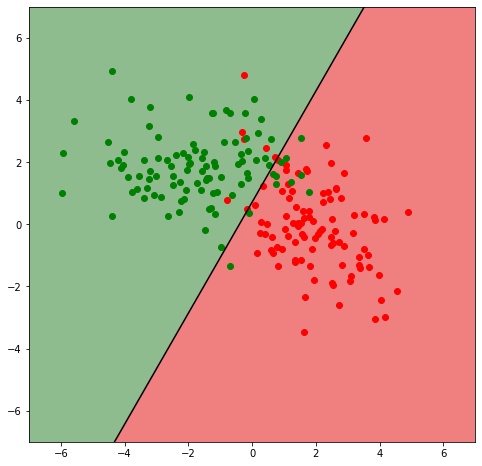

In [ ]:
trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis = df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [8,8])
plt.xlim([-7,7])
plt.ylim([-7,7])
xgrid = np.linspace(-7,7,1000)
ygrid = np.linspace(-7,7,1000)
xx, yy = np.meshgrid(xgrid, ygrid)
r1 = xx.flatten()
r2 = yy.flatten()
numGrid = len(r1)

r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2), 1))
preds = np.zeros(numGrid)
for i in range(numGrid):
  preds[i] = LDA(np.array([r1[i], r2[i]]).reshape((2,1))) + 1
zz = preds.reshape(xx.shape)


plt.contourf(xx, yy, zz, colors = ['darkseagreen', 'lightcoral'])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')



# The equation below was found in matlab. It was done by setting the 
# score functions of each class equal to eachother and then using the solve function.
# below is the code I used to generate the function
  #x1 = sym('x1');
  #x2 = sym('x2');
  #m1 = [-1.72514029;1.86010171];
  #m2 = [ 1.94477205; -0.0323033 ];
  #C = [2.19271609,-0.35584343;-0.35584343, 1.56907005]
  #x = [x1;x2];

  #f1 = x.' * inv(C) * m1 - 0.5 * m1.' * inv(C) * m1 + log(.5);
  #f2 = x.' * inv(C) * m2 - 0.5 * m2.' * inv(C) * m2 + log(.5);

  #x2_S = solve(f1 == f2, [x2]);
  #x2_S = simplify(x2_S);
  #expand(vpa(x2_S))




eqn1 = 1.78821*xgrid + 0.71753
plt.plot(xgrid, eqn1, c = 'black')

plt.show()

### (b)

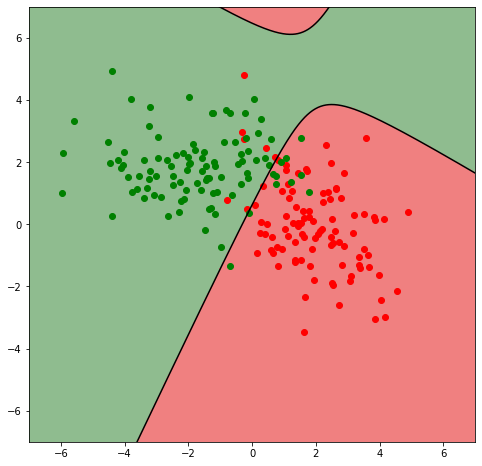

In [ ]:
trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis =df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [8,8])
plt.xlim([-7,7])
plt.ylim([-7,7])
xgrid = np.linspace(-7,7,1000)
ygrid = np.linspace(-7,7,1000)
xx, yy = np.meshgrid(xgrid, ygrid)
r1 = xx.flatten()
r2 = yy.flatten()
numGrid = len(r1)

r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2), 1))
preds = np.zeros(numGrid)
for i in range(numGrid):
  preds[i] = QDA(np.array([r1[i], r2[i]]).reshape((1,2))) + 1
zz = preds.reshape(xx.shape)
plt.contourf(xx, yy, zz, colors = ['darkseagreen', 'lightcoral'])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')


# The matlab code used to find the equations below is as follows
  #x1 = sym('x1');
  #x2 = sym('x2');
  #m1 = [-1.72514029;1.86010171];
  #m2 = [ 1.94477205; -0.0323033 ];
  #C1 = [2.89948393, -0.02830558; -0.02830558, 1.09745585];
  #C2 = [1.48594825, -0.68338128; -0.68338128,  2.04068415];
  #x = [x1;x2];
  #f1 = -.5*x.'* inv(C1) * x + x.'*inv(C1)*m1 - .5*m1.'*inv(C1) * m1 - .5* log(det(C1)) + log(.5);
  #f2 = -.5*x.'* inv(C2) * x + x.'*inv(C2)*m2 - .5*m2.'*inv(C2) * m2 - .5* log(det(C2)) + log(.5);
  #x2_S = solve(f1 == f2, [x2]);
  #x2_S = simplify(x2_S);
  #expand(vpa(x2_S))


eqn1 = 0.7751409 * xgrid - np.sqrt(1.9570244*np.square(xgrid)-7.23593*xgrid+8.530239) + 3.55414
eqn2 = 0.7751409 * xgrid + np.sqrt(1.9570244*np.square(xgrid)-7.23593*xgrid+8.530239) + 3.55414
plt.plot(xgrid, eqn1, c = 'black')
plt.plot(xgrid, eqn2, c = 'black')

plt.show()

### (c)

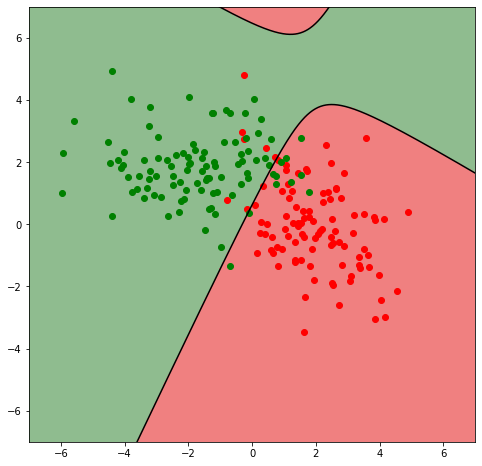

In [ ]:
trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis =df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [8,8])
plt.xlim([-7,7])
plt.ylim([-7,7])
xgrid = np.linspace(-7,7,1000)
ygrid = np.linspace(-7,7,1000)
xx, yy = np.meshgrid(xgrid, ygrid)
r1 = xx.flatten()
r2 = yy.flatten()
numGrid = len(r1)

r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2), 1))
preds = np.zeros(numGrid)
for i in range(numGrid):
  preds[i] = GNB(np.array([r1[i], r2[i]]).reshape((2,1))) + 1
zz = preds.reshape(xx.shape)
plt.contourf(xx, yy, zz, colors = ['darkseagreen', 'lightcoral'])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')



# The matlab code used to find the equations below is as follows
  #x1 = sym('x1');
  #x2 = sym('x2');
  #m1 = [-1.72514029;1.86010171];
  #m2 = [ 1.94477205; -0.0323033 ];

  #C1 = [2.89948393, -0.02830558; -0.02830558, 1.09745585];
  #C2 = [1.48594825, -0.68338128; -0.68338128,  2.04068415];
  #x = [x1;x2];
  #f1 = (1/(2*pi*sqrt(det(C1)))) * exp(-0.5*(x - m1).' * inv(C1) * (x-m1));
  #f2 = (1/(2*pi*sqrt(det(C2)))) * exp(-0.5*(x - m2).' * inv(C2) * (x-m2));
  #x2_S = solve(f1 == f2, [x2]);
  #x2_S = simplify(x2_S);
  #expand(vpa(x2_S))

eqn1 = 0.775141 * xgrid - 1.15954* np.sqrt(1.45554*np.square(xgrid)-5.38172*xgrid+6.34436) + 3.55414
eqn2 = 0.775141 * xgrid + 1.15954* np.sqrt(1.45554*np.square(xgrid)-5.38172*xgrid+6.34436) + 3.55414
plt.plot(xgrid, eqn1, c = 'black')
plt.plot(xgrid, eqn2, c = 'black')


plt.show()

### (d)

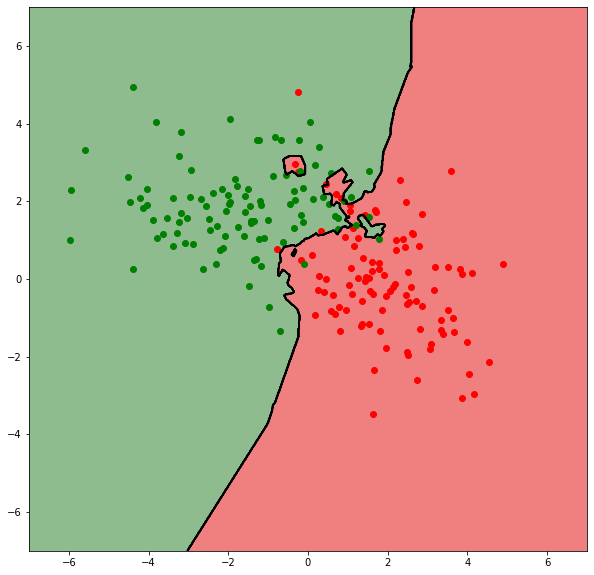

In [ ]:
trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis =df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [10,10])
plt.xlim([-7,7])
plt.ylim([-7,7])
xgrid = np.linspace(-7,7,1000)
ygrid = np.linspace(-7,7,1000)
xx, yy = np.meshgrid(xgrid, ygrid)
r1 = xx.flatten()
r2 = yy.flatten()
numGrid = len(r1)

r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2), 1))
preds = np.zeros(numGrid)
for i in range(numGrid):
  preds[i] = KNN(np.array([r1[i], r2[i]]).reshape((2,1)), 3) + 1
zz = preds.reshape(xx.shape)
plt.contour(xx, yy, zz, colors = 'black')
plt.contourf(xx, yy, zz, colors = ['darkseagreen', 'lightcoral'])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')
plt.show()

### (e)

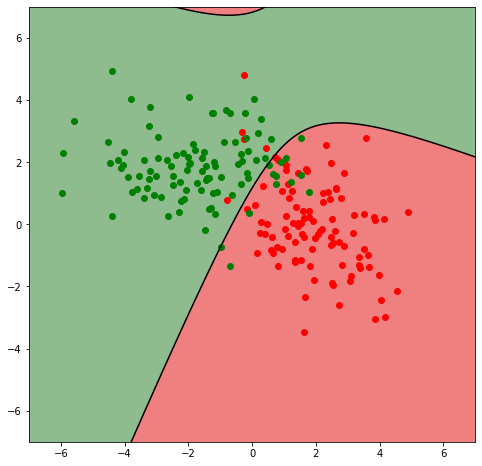

In [ ]:
def IB(sample):
  prob = np.zeros(2)
  mu_IB = np.array([[-2,2],[2,0]])
  C_IB = np.array([[[3,0],[0,1]],[[2,-1],[-1,2]]])
  for i in range(2):
      p = 1/(2*np.pi*np.sqrt(np.linalg.det(C_IB[i])))
      exponent = -.5*np.matmul((sample.T-mu_IB[i]), np.matmul(np.linalg.inv(C_IB[i]),(sample.T-mu_IB[i]).T))
      p = p * np.exp(exponent)
      prob[i] = p
  if(prob[0] > prob[1]):
    return 0
  return 1

trainSenioritis = df_train.loc[df_train['ClassLabel'] == 'Senioritis']
trainNoSenioritis =df_train.loc[df_train['ClassLabel'] != 'Senioritis']
trainPlot = plt.figure(figsize = [8,8])
plt.xlim([-7,7])
plt.ylim([-7,7])
xgrid = np.linspace(-7,7,1000)
ygrid = np.linspace(-7,7,1000)
xx, yy = np.meshgrid(xgrid, ygrid)
r1 = xx.flatten()
r2 = yy.flatten()
numGrid = len(r1)

r1, r2 = r1.reshape((len(r1),1)), r2.reshape((len(r2), 1))
preds = np.zeros(numGrid)
for i in range(numGrid):
  preds[i] = IB(np.array([r1[i], r2[i]]).reshape((2,1))) + 1
zz = preds.reshape(xx.shape)
plt.contourf(xx, yy, zz, colors = ['darkseagreen', 'lightcoral'])
plt.scatter(trainSenioritis['ChemA'], trainSenioritis['ChemB'], c='r')
plt.scatter(trainNoSenioritis['ChemA'], trainNoSenioritis['ChemB'], c='g')

# The matlab code used to generate the equations below is as follows
  #x1 = sym('x1');
  #x2 = sym('x2');
  #x = [x1;x2];
  #mIB1 = [-2;2];
  #mIB2 = [2;0];
  #CIB1 = [3,0;0,1];
  #CIB2 = [2,-1;-1,2];
  #f1 = (1/(2*pi*sqrt(det(CIB1)))) * exp(-0.5*(x - mIB1).' * inv(CIB1) * (x-mIB1));
  #f2 = (1/(2*pi*sqrt(det(CIB2)))) * exp(-0.5*(x - mIB2).' * inv(CIB2) * (x-mIB2));
  #x2_S = solve(f1 == f2, [x2]);
  #x2_S = simplify(x2_S);
  #expand(vpa(x2_S))


eqn1 = xgrid - 1.41421* np.sqrt(np.square(xgrid)-2*xgrid+4) + 4
eqn2 = xgrid + 1.41421* np.sqrt(np.square(xgrid)-2*xgrid+4) + 4
plt.plot(xgrid, eqn1, c = 'black')
plt.plot(xgrid, eqn2, c = 'black')

plt.show()

## Problem 1.6


### (a)

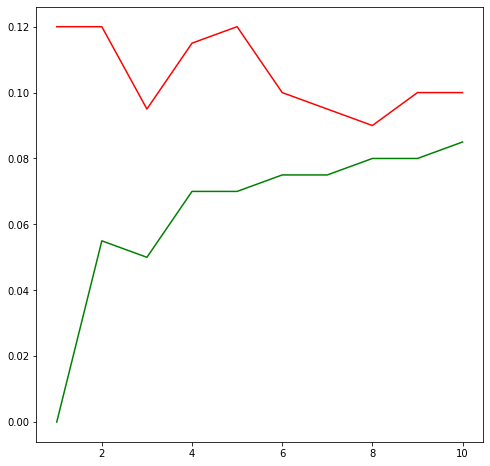

In [ ]:
def calculateError(df_f, k):
  np_df_f = df_f.to_numpy()
  numCorrect = 0
  for i in np_df_f:
    classNum = knnDictionary[i[0]]
    if(classNum == knnDictionary[KNN(i[1:3],k)]):
      numCorrect += 1
  return 1-(numCorrect/df_f.shape[0])


trainError = np.zeros(10)
testError = np.zeros(10)

for i in range(10):
  trainError[i] = calculateError(df_train,i+1)
  testError[i] = calculateError(df_test, i+1)

errorPlot = plt.figure(figsize = [8,8])
x = np.linspace(1,10,10)
plt.plot(x,trainError, c = 'g', label = 'Training Data')
plt.plot(x,testError, c = 'r', label = 'Testing Data')
plt.show()

### (b)

I would recommend a K value of 8 goes into production. This is because it has the lowest value of error when test data is used. Training data should not be used to make decisions such as which value of K goes into production. This is due to cross validation.